<a href="https://colab.research.google.com/github/STASYA00/IAAC2024_tutorials/blob/main/quickstarts/01_object_tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> - Stasja's notebook

In [ ]:
!git clone https://github.com/STASYA00/IAAC2024_tutorials
%cd IAAC2024_tutorials
!pip install -r requirements.txt
%cd quickstarts

In [2]:
import cv2
import matplotlib.pyplot as plt
import torch

from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
from torchvision.transforms.functional import to_pil_image
from torchvision.io import read_image

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

# %matplotlib inline

/home/sta/envs/iaac2024/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 🎯 Object Detection and Tracking

### 🫧 Object Detection. Yolo

[YOLO explained](https://medium.com/analytics-vidhya/yolo-explained-5b6f4564f31)\
[YOLO paper](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Redmon_You_Only_Look_CVPR_2016_paper.pdf)

In [5]:
model = torch.hub.load('ultralytics/yolov5', "yolov5l") 

Using cache found in /home/sta/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-4-6 Python-3.10.6 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)

100%|██████████| 89.3M/89.3M [00:05<00:00, 16.9MB/s]

Fusing layers... 


: 

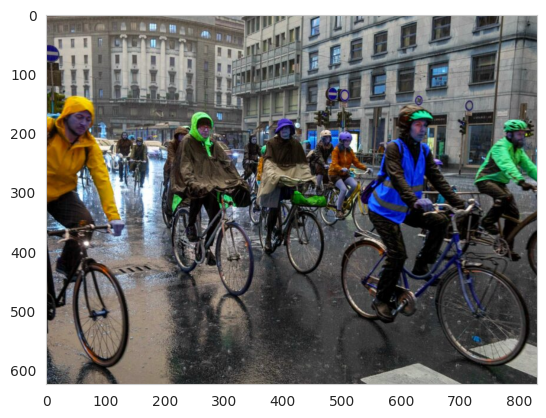

In [4]:
img = cv2.imread("../.assets/cycles.jpg")
plt.imshow(img)

In [ ]:
preds = model(img)
preds

In [26]:
cap = cv2.VideoCapture('../.assets/2.mp4')

In [9]:
ret, frame = cap.read(0)
plt.imshow(frame)


In [10]:
preds = model(frame)
preds

YOLOv5 <class 'models.common.Detections'> instance
image 1/1: 720x1280 17 persons, 2 cars, 1 truck, 3 traffic lights, 3 benchs, 1 potted plant
Speed: 13.1ms pre-process, 287.0ms inference, 538.3ms NMS per image at shape (1, 3, 384, 640)

In [11]:
# preds.names

In [12]:
CATEGORY = 0
CONFIDENCE = 0.1
preds = preds.xywh[0]
preds = preds[preds[:, -1]==CATEGORY]
preds = preds[preds[:, -2]>=CONFIDENCE]

In [13]:
x, y, w, h = [int(p) for p in preds[0][:4]]
x1 = int(x - 0.5 * w)
y1 = int(y - 0.5* h)
x2 = int(x + 0.5 * w)
y2 = int(y + 0.5* h)
frame = cv2.rectangle(frame, (x1,y1), (x2, y2), (255,255,255), 1)

In [14]:
# cv2.imwrite("../.assets/res.png", frame)
plt.imshow(frame)

Let's write all predictions to our image:

In [15]:
for pred in preds:
    x, y, w, h = [int(p) for p in pred[:4]]
    x1 = int(x - 0.5 * w)
    y1 = int(y - 0.5* h)
    x2 = int(x + 0.5 * w)
    y2 = int(y + 0.5* h)
    frame = cv2.rectangle(frame, (x1,y1), (x2, y2), (255,255,255), 1)


In [16]:
# cv2.imwrite("../.assets/res.png", frame)

plt.imshow(frame)

In [17]:
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(total_frames)

4703


In [18]:
ppl_density = []
for f in range(total_frames):
    ret, frame = cap.read(f)
    if ret == True: 
        preds = model(frame)
        preds = preds.xywh[0]
        preds = preds[preds[:, -1]==CATEGORY]
        preds = preds[preds[:, -2]>=CONFIDENCE]
        ppl_density.append(len(preds))
    

In [19]:
len(ppl_density)

4702

In [20]:
sns.lineplot(ppl_density)

<Axes: >

Let's write a function to draw predictions on a frame:

In [22]:
def draw_predictions(frame, predictions, color = (255,255,255)):
    """
    Function to draw bounding boxes from predictions on the given image.
    :param: frame           image to draw the boxes on, np.ndarray, (h, w, ch)
    :param: predictions     predictions to draw, torch.tensor
    :param: color           color to use for bounding box outline rgb, tuple, default (255,255,255)
    """
    for pred in predictions:
        x, y, w, h = [int(p) for p in pred[:4]]
        x1 = int(x - 0.5 * w)
        y1 = int(y - 0.5* h)
        x2 = int(x + 0.5 * w)
        y2 = int(y + 0.5* h)
        frame = cv2.rectangle(frame, (x1,y1), (x2, y2), color, 1)
    return frame

In [27]:
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
out = cv2.VideoWriter('outpy.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width, frame_height))

In [28]:
for f in range(total_frames):
    ret, frame = cap.read(f)
    if ret == True: 
        preds = model(frame)
        preds = preds.xywh[0]
        preds = preds[preds[:, -1]==CATEGORY]
        preds = preds[preds[:, -2]>=CONFIDENCE]
        ppl_density.append(len(preds))
        frame = draw_predictions(frame, preds)
        out.write(frame)

cap.release()
out.release()

### Convert the video in mp4 format:

In [ ]:
!ffmpeg -i outpy.avi out.mp4 

And speed it up:

In [ ]:
!ffmpeg -i out.mp4 -vf  "setpts=0.20*PTS" out_x5.mp4

## Tracking

In [ ]:
%cd ../
!git submodule add https://github.com/STASYA00/deep_sort.git
!git submodule update --remote
%cd deep_sort
%pip install -r requirements.txt
% cd ../notebooks

In [39]:
import sys
sys.path.append("..")

In [42]:
from deep_sort.deep_sort import DeepSort

In [43]:
tracker = DeepSort("osnet_x0_25")

Downloading...
From: https://drive.google.com/uc?id=1rb8UN5ZzPKRc_xvtHlyDh-cSz88YX9hs
To: /home/sta/.cache/torch/checkpoints/osnet_x0_25_imagenet.pth
100%|██████████| 2.97M/2.97M [00:00<00:00, 3.51MB/s]


Successfully loaded imagenet pretrained weights from "/home/sta/.cache/torch/checkpoints/osnet_x0_25_imagenet.pth"


In [44]:
def yolo2standard(xyxy) -> list:
    """
    Function that brings yolo bbox xyxy annotation to standard format [left, top, w, h]
    """
    w = xyxy[2] - xyxy[0]
    h = xyxy[3] - xyxy[1]
    return [xyxy[0], xyxy[1], w, h]



Looping over the video:

In [ ]:
seen_people = []


for f in range(total_frames):
    ret, frame = cap.read(f)
    if ret == True: 
        preds = model(frame)
        preds = tracker.update(preds[:, :4].cpu(), preds[:,4].cpu(), preds[:,-1].cpu(), frame)

        # filter out predictions
        for r in preds:
            label = r[4]
            if label == CATEGORY:
                if not label in seen_people:
                    seen_people.append(label)

                r = yolo2standard(r)
                frame = draw_predictions(frame, [r])
        out.write(frame)

cap.release()
out.release()